In [17]:
import pandas as pd
import numpy as np
from keras import layers
from keras.models import Sequential
from keras.optimizers import RMSprop
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

# ##============= Data loading and processing =============##
# loading dataset into the program
dataset1 = pd.read_csv('London 2000-01-01 to 2024-01-31.csv', index_col="datetime")
dataset2 = pd.read_csv(r'tfl-daily-cycle-hires.csv', index_col="Day", parse_dates=["Day"])

# define the features we want to predict, focus on only max temperature now
target_features = ['tempmax', 'tempmin', 'windspeed', 'precip', 'Number of Bicycle Hires']

# filter dataset1 from 2010.07.30 to 2024.01.31 to fit with dataset2
start_date = pd.to_datetime('2010-07-30')
dataset1.index = pd.to_datetime(dataset1.index)
dataset1_filtered = dataset1[(dataset1.index >= start_date)]

# delete useless columns and columns with too many NaN values
dataset1_filtered.drop(columns=['name', 'severerisk', 'windgust',
                                'preciptype', 'precipprob', 'solarradiation',
                                'solarenergy', 'uvindex', 'sunrise',
                                'sunset', 'conditions', 'description',
                                'icon', 'stations', 'sunset'],
                       inplace=True)

# combining the two datasets
merged_data = pd.merge(dataset1_filtered, dataset2, left_index=True, right_index=True, how='outer')

# change the values of bike hires to float
merged_data['Number of Bicycle Hires'] = merged_data['Number of Bicycle Hires'].apply(lambda x: float(x.replace(',', '')))

# show the merged dataset
merged_data

C:\Users\12783\AppData\Local\Temp\ipykernel_37460\1629301967.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1_filtered.drop(columns=['name', 'severerisk', 'windgust',


,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipcover,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,visibility,moonphase,Number of Bicycle Hires
datetime,,,,,,,,,,,,,,,,,,,
2010-07-30,22.3,14.0,17.9,22.3,14.0,17.9,10.5,63.0,0.000,0.00,0.0,0.0,21.3,250.6,1014.8,60.3,32.9,0.65,6897.0
2010-07-31,23.5,17.6,20.1,23.5,17.6,20.1,14.3,71.3,1.995,8.33,0.0,0.0,22.7,242.6,1011.6,64.1,31.1,0.68,5564.0
2010-08-01,22.8,15.3,18.8,22.8,15.3,18.8,11.7,64.8,0.000,0.00,0.0,0.0,14.6,261.1,1013.2,62.3,38.7,0.71,4303.0
2010-08-02,22.1,16.3,18.9,22.1,16.3,18.9,11.1,60.9,0.299,4.17,0.0,0.0,15.1,344.5,1016.6,63.3,36.6,0.75,6642.0
2010-08-03,21.8,13.0,18.0,21.8,13.0,18.0,11.6,67.3,0.000,0.00,0.0,0.0,20.0,247.9,1016.0,54.3,30.7,0.75,7966.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-27,8.6,1.1,5.0,6.6,-0.6,3.3,2.0,81.8,0.000,0.00,0.0,0.0,18.1,180.3,1032.7,33.1,15.9,0.56,16959.0
2024-01-28,11.5,3.1,7.0,11.5,0.5,5.4,4.1,82.4,0.000,0.00,0.0,0.0,13.8,169.7,1022.7,33.5,15.2,0.59,15540.0
2024-01-29,12.1,8.6,10.8,12.1,7.2,10.5,8.8,87.3,0.000,0.00,0.0,0.0,20.8,182.3,1022.0,95.9,8.4,0.62,22839.0


In [18]:
# Filling in the missing data in columns by the previous day values
merged_data=merged_data.ffill()

# Checking again the number of missing data in every column after filling in the missing values
print(merged_data.isnull().sum())

tempmax                    0
tempmin                    0
temp                       0
feelslikemax               0
feelslikemin               0
feelslike                  0
dew                        0
humidity                   0
precip                     0
precipcover                0
snow                       0
snowdepth                  0
windspeed                  0
winddir                    0
sealevelpressure           0
cloudcover                 0
visibility                 0
moonphase                  0
Number of Bicycle Hires    0
dtype: int64


In [19]:
# Checking datatypes of each column to ensure are of correct types for ML processing
print(merged_data.dtypes)

tempmax                    float64
tempmin                    float64
temp                       float64
feelslikemax               float64
feelslikemin               float64
feelslike                  float64
dew                        float64
humidity                   float64
precip                     float64
precipcover                float64
snow                       float64
snowdepth                  float64
windspeed                  float64
winddir                    float64
sealevelpressure           float64
cloudcover                 float64
visibility                 float64
moonphase                  float64
Number of Bicycle Hires    float64
dtype: object


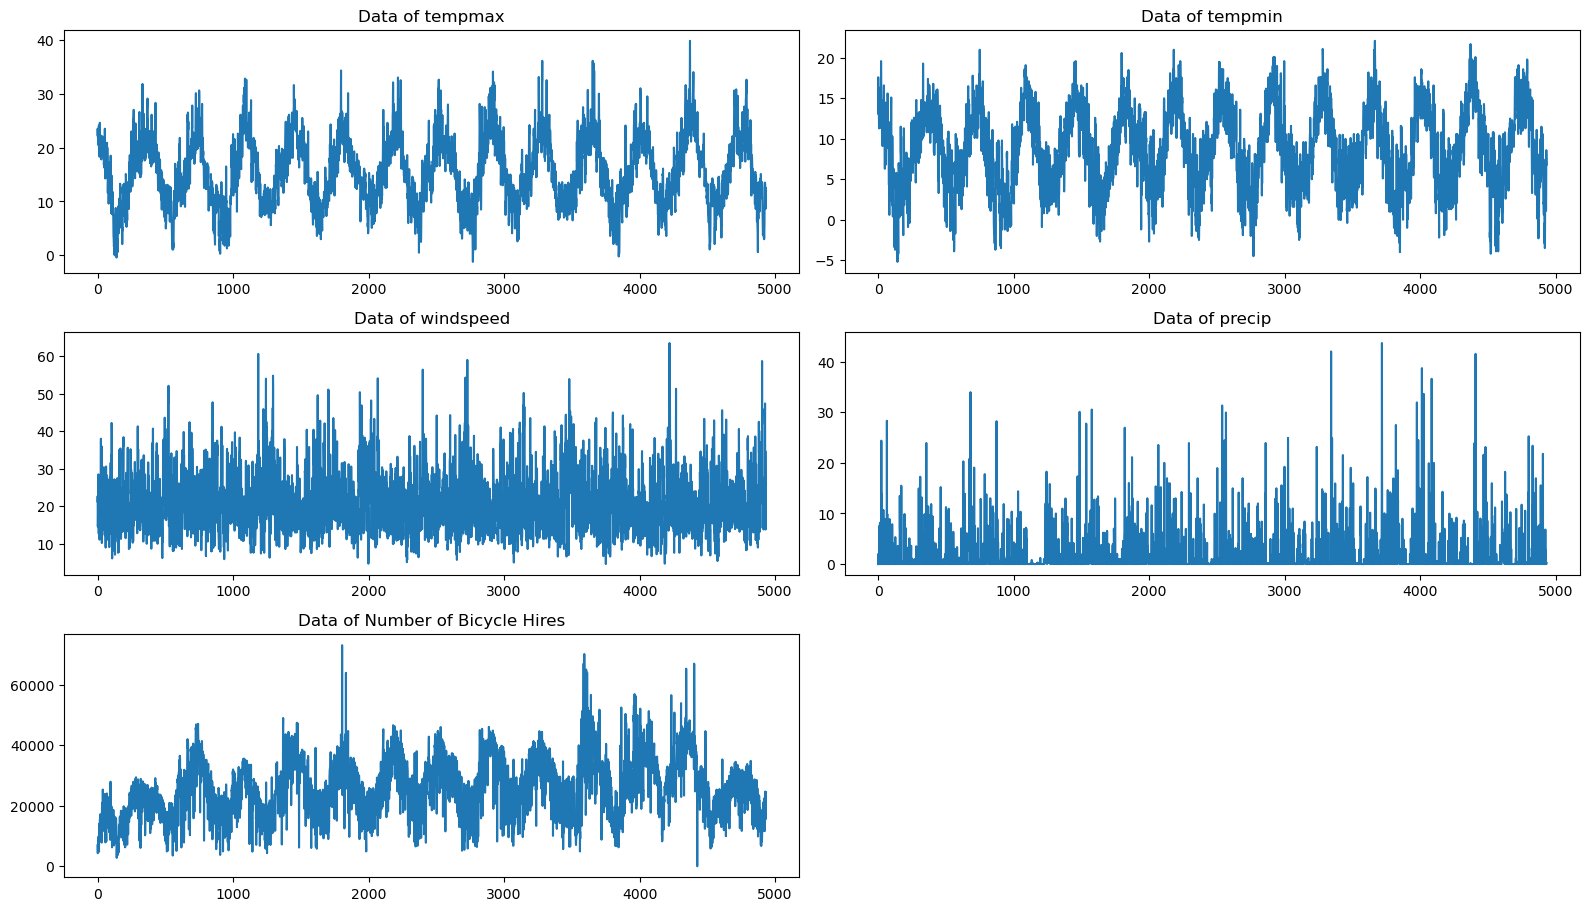

In [20]:
# Analyze the read weather data and draw temperature data
plt.figure(figsize=(16, 12))
for i,feature in enumerate(target_features):
    value = merged_data.loc[:, feature]
       
    plt.subplot(4, 2, i+1)
    plt.plot(range(len(value)), value)	# paint all data
    plt.title('Data of '+ feature)
    
plt.tight_layout()
plt.show()

In [21]:
# ##======== Prepare the data sets required for the model ========##
# Normalise data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(merged_data)
scaled_data = pd.DataFrame(scaled_data, columns=merged_data.columns)
std = merged_data.loc[:, target_features].std(axis=0)

In [22]:
# Specify the ratio of training set, validation set, and test set
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Calculate the size of the training, validation, and testing sets
train_size = int(len(scaled_data) * train_ratio)
val_size = int(len(scaled_data) * val_ratio)

From here, you can change the value of N to define which day you want to predict.

In [23]:
lookback = 30   # use the data of last 30 days to predict that of next day
N = 3           # forecast the weather on the Nth day
forecast = N-1    

# generate x_train and y_train
x_train = []
y_train = []
for i in range(lookback+forecast, train_size+1):
    x_train.append(scaled_data[i-lookback-forecast:i-forecast])
    y_train.append(scaled_data.loc[i, target_features])
x_train, y_train = np.array(x_train), np.array(y_train)

# generate x_val and y_val
x_val = []
y_val = []
for i in range(train_size+forecast, train_size+val_size+1):
    x_val.append(scaled_data[i-lookback-forecast:i-forecast])
    y_val.append(scaled_data.loc[i, target_features])
x_val, y_val = np.array(x_val), np.array(y_val)

# generate x_test and y_test
x_test = []
y_test = []
for i in range(train_size+val_size+forecast, len(scaled_data)):
    x_test.append(scaled_data[i-lookback-forecast:i-forecast])
    y_test.append(scaled_data.loc[i, target_features])
x_test, y_test = np.array(x_test), np.array(y_test)

In [24]:
x_test.shape

(739, 30, 19)

In [25]:
# A common sense based, non machine learning method is
# used to calculate the MAE (Mean Absolute Error) of a
# common sense based method that always predicts that
# the next day's data is equal to the previous day's data.
target_feature_index = [merged_data.columns.get_loc(feature) for feature in target_features]
y_pred = np.empty(y_test.shape)
for i in range(x_test.shape[0]):
    y_pred[i] = x_test[i, -1, target_feature_index]
error = y_pred - y_test
referencing_mae = np.mean(np.abs(error), axis=0)*std
    
print(f'Reference Error on Day {N} :')
referencing_mae

Reference Error on Day 3 :


tempmax                       2.729641
tempmin                       2.581317
windspeed                     7.531886
precip                        2.389626
Number of Bicycle Hires    5834.470849
dtype: float64

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 32)          6656      
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 5)                 85        
                                                                 
Total params: 9,877
Trainable params: 9,877
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
27/27 [==============================] - 9s 127ms/step - loss: 0.6333 - val_loss: 0.6422
Epoch 2/25
27/27 [==============================] - 3s 100ms/step - loss: 0.5522 - val_loss: 0.6019
Epoch 3/25
27/27 [==============================] - 4s 141ms/step - loss: 0.5290 - val_loss: 0.5870
Epoch 4/25
27/27 [

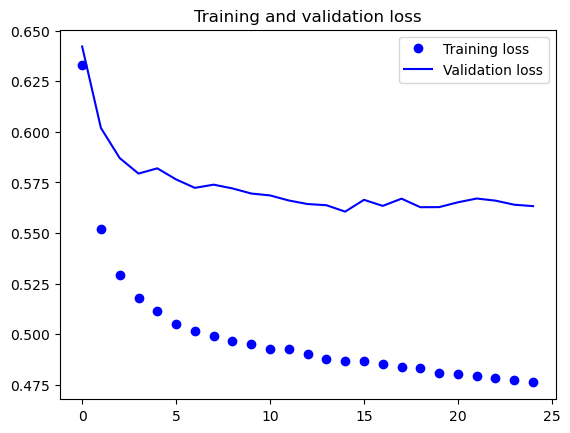

In [26]:
# ##=========== build and train the model ===========##
# Train and evaluate a stacked LSTM model using dropout regularization
model = Sequential()
model.add(layers.LSTM(32,
                      dropout=0.1,
                      recurrent_dropout=0.5,
                      return_sequences=True,
                      input_shape=(None, scaled_data.shape[-1])))
model.add(layers.LSTM(16,
                      activation='relu',
                      dropout=0.1,
                      recurrent_dropout=0.5))
model.add(layers.Dense(len(target_features)))
model.summary()

# compile and train the model
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='mae')
history = model.fit(x_train, y_train,
                    epochs=25,
                    batch_size=128,
                    validation_data=(x_val, y_val))

# paint the result
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [34]:
# ##================ test the model ================##
# calculate the mae of each feature separately.
# denormalization the error, which shows the average error
# measured in Celsius degree.
error = model.predict(x_test) - y_test
test_mae = np.mean(np.abs(error), axis=0)*std

mae = {'Reference Error': referencing_mae, 'Prediction Test Error': test_mae}
mae = pd.DataFrame(mae)
print(f'Reference Error and Prediction Test Error on Day {N} :')
mae

24/24 [==============================] - 1s 13ms/step
Reference Error and Test Error on Day 3 :


,Reference Error,Test Error
tempmax,2.729641,2.563814
tempmin,2.581317,2.317472
windspeed,7.531886,5.719302
precip,2.389626,1.597409
Number of Bicycle Hires,5834.470849,4681.152825


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, None, 32)          6656      
                                                                 
 lstm_3 (LSTM)               (None, 16)                3136      
                                                                 
 dense_1 (Dense)             (None, 5)                 85        
                                                                 
Total params: 9,877
Trainable params: 9,877
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
27/27 [==============================] - 9s 118ms/step - loss: 0.6167 - val_loss: 0.6241
Epoch 2/25
27/27 [==============================] - 3s 95ms/step - loss: 0.5448 - val_loss: 0.6030
Epoch 3/25
27/27 [==============================] - 3s 96ms/step - loss: 0.5248 - val_loss: 0.5884
Epoch 4/25
27/27 [

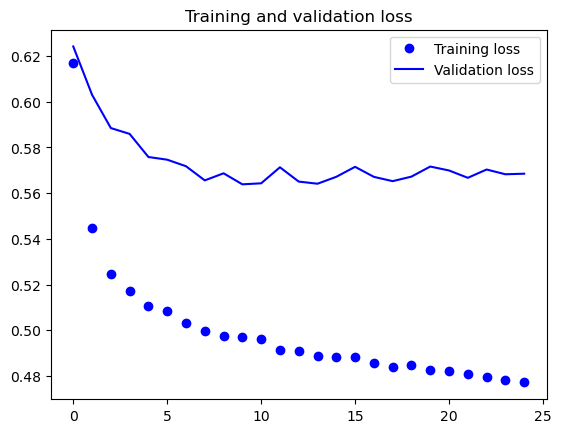

In [35]:
# ##=========== build and train the model ===========##
# Train and evaluate a stacked LSTM model using dropout regularization
model = Sequential()
model.add(layers.LSTM(32,
                      dropout=0.1,
                      recurrent_dropout=0.5,
                      return_sequences=True,
                      input_shape=(None, scaled_data.shape[-1])))
model.add(layers.LSTM(16,
                      activation='relu',
                      dropout=0.1,
                      recurrent_dropout=0.5))
model.add(layers.Dense(len(target_features)))
model.summary()

# compile and train the model
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='mae')
history = model.fit(x_train, y_train,
                    epochs=25,
                    batch_size=128,
                    validation_data=(x_val, y_val))

# paint the result
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [36]:
# ##================ test the model ================##
# calculate the mae of each feature separately.
# denormalization the error, which shows the average error
# measured in Celsius degree.
error = model.predict(x_test) - y_test
test_mae = np.mean(np.abs(error), axis=0)*std

mae = {'Reference Error': referencing_mae, 'Prediction Test Error': test_mae}
mae = pd.DataFrame(mae)
print(f'Reference Error and Prediction Test Error on Day {N} :')
mae

24/24 [==============================] - 1s 13ms/step
Reference Error and Prediction Test Error on Day 3 :


,Reference Error,Test Error
tempmax,2.729641,2.635207
tempmin,2.581317,2.320635
windspeed,7.531886,5.764224
precip,2.389626,1.627103
Number of Bicycle Hires,5834.470849,5172.698092
